# Fitting sum of exponentials
## Joseph Palmer
### Imperial College London & Royal Holloway University of London
### 05/06/2019
---

#### Background 
The exponential distribution takes the following forms:

\begin{equation}
\frac{1}{\lambda} e^{-\frac{\lambda}{x}}
\end{equation}
or:
\begin{equation}
\lambda e^{-\lambda x}
\end{equation}

These single exponentials can be combined in a sum to produce a sum of exponentials. Each individual exponential in the sum is mediated by a weighting factor $p$, which take the following constraints (equality or inequality?):

$0 \leq p \leq 1$
;
$0 < \sum p \leq 1$

The sum of exponentials allows different individual exponentials to model certain aspects of the data with the $p$ value acting as a switch to moderate their respective influence on the data.

The following shows the equation for a sum of 3 exponentials:

\begin{equation}
p_1\lambda_1 e^{-\lambda_1 x} + p_2\lambda_2 e^{-\lambda_2 x} + (1 - p_1 - p_2)\lambda_3 e^{-\lambda_3 x}
\end{equation}

This form is extendable through n:

\begin{equation}
\sum_{i}^{n-1}[p_i\lambda_i e^{-\lambda_i x}] + (1 - p_1 - p_2,..., p_n)\lambda_n e^{-\lambda_n x}
\end{equation}

#### Sampling
The sum of exponentials can be sampled from using the following routine: 

1) Make a list of rates and p values  
2) Sample each rate from the list using the associated p weights as the probability of selecting that rate.  
3) Draw a value from a expnential distribution with the sampled rate and append it to a list.

The following python function does this:

In [1]:
# set imports
import numpy as np
from scipy.optimize import minimize
import sympy
import warnings
import matplotlib.pyplot as plt
import pandas as pd

# Make warnings show as errors
warnings.filterwarnings("error")

# set seed on random number generator for demonstrating
np.random.seed(7)

In [2]:
# set seed on random number generator for demonstrating
np.random.seed(7)

def sample_sumexp(size, comb):
    selection = np.random.choice([i for i in comb.values()],
                                p = [i for i in comb.keys()],
                                size = size)
    sse = np.zeros(shape=(size, 1))
    for i in range(len(selection)):
        sse[i] = np.random.exponential(selection[i], 1)
    return sse

#### Optimization
The data can then be modeled using the sum of exponentials equation. First, we will set the rates to those used in sample_sumexp() (1.6, 1.11, 0.7) and try to numerically optomize the remaining p weights. The optimizer used is from scipy.optimize.minimize and uses the fitting method [l-bfgs-b](https://en.wikipedia.org/wiki/Limited-memory_BFGS). The following functions build the required equation based on the number of rates wanted and minimizes the negative loglikelihood to return the most likely paramater values for the data and model.

In [3]:
# set seed on random number generator for demonstrating
np.random.seed(7)

def symbolise(eq, args):
    # convert string equation and paramaters to sympy object
    args_list = [None for i in range(len(args))]
    for i in range(len(args)):
        vars()[args[i]] = sympy.Symbol(args[i])
        args_list[i] = vars()[args[i]]
    symbol_args = tuple(i for i in args_list)
    return (eval(eq), symbol_args)

def build_equation(size):
    # build the equation as a string from the number of rates
    rates = ["r{}".format(i) for i in range(size)]
    probs = ["p{}".format(i) for i in range(size - 1)]
    sums = ["{p}*{r}*sympy.exp(-{r}*y)".format(p = probs[i],
        r = rates[i]) for i in range(size - 1)]
    last = "((1-{l})*{r})*sympy.exp(-{r}*y)".format(l = "-".join(probs),
            r = rates[-1])
    eq = "{}+{}".format("+".join(sums), last)
    args = (*rates, *probs, "y")
    return eq, args

def render(size, params, x):
    # convert sympy equation into python function
    eq, args = symbolise(*build_equation(size))
    func = sympy.lambdify(args, eq)
    # fix rates
    pnumber = size - 1
    rates = [1.6, 1.11, 0.7]
    params = [*rates, *params]
    f_args = [*params, x]
    return func(*f_args)

def penalty(params):
    # impose penalty if the sum of paramaters is not between 0 and 1 and if 1 - sum
    # params is greater than 1 or less than 0
    if 1 - sum(params) > 1 or 1 - sum(params) < 0:
        return np.inf
    elif sum(params) > 1 or sum(params) < 0:
        return np.inf
    return False

def minimize_nll(params, x):
    # return the negative log-likelihood for the paramaters
    size = 3
    cost = penalty(params)
    if cost:
        return cost
    loglike = sum(np.log(render(size, params, x)))
    return -loglike

def minimize_model(data, startest, bounds):
    # run the optimizer on the data and equation
    kwargs = {"method" : "l-bfgs-b", "bounds" : bounds}
    args = (minimize_nll,
            startest,
            data)
    model = minimize(*args, **kwargs)
    return model

Using the functions defined above we will optimize the p values for a 3 rate sum of exponentials with rates 1.6, 1.11 and 0.7. 

The number of p values is equal to the number of rate values minus 1 (np = rates - 1) as the last p value is calculated from the other two values (1 - p1 - p2). The starting estimates used must sum to around 0.5 for the optimiser to be able to work effectivley. This is because the optimiser will try and change the values as much as it can in the initial itterations to see what the effects are. If the changes result in the p values exceding 1 then an infinate number is returned. Whilst this is effective at keeping the optimizer in check, at the initial stages it can prevent the paramaters from being optimise by convincing the optimizer that any change in the paramaters produces a lower likelihood. The solution is to vary the starting estimates so they can change without going outside of their bounds and allow the optimizer space to explore. 

The bounds on the p values are: $0<p<1$ 

In [4]:
# set seed on random number generator for demonstrating
np.random.seed(7)

# Set the data size and dictionary or probabilities and rates for sumexp sampling
data_size = 10000
comb = {0.3:1.6,
        0.5:1.11,
        0.2:0.7}
in_wp = list(comb.keys())[:2]

# generate data from sum of exponentials function defined
simdata = sample_sumexp(data_size, comb)

# set size as number of rate values
size = 3

# starting estimates
startest = [0.3, 0.3]

# bounds
bounds = ((0, 1),) * (size -1)

# run the model
model = minimize_model(simdata, startest, bounds)

# show results
p3 = eval("1 - {}".format("-".join([str(i) for i in model.x])))
p1, p2 = [i for i in model.x]
optimized_vals = [p1, p2, p3]
print("-Model-\n{}\n\n"
      "- {} Simulations -\n"
      "Input p values     : {}\n"
      "Estimated p values : {}\n\n".format(model,
                                            data_size,
                                            list(comb.keys()),
                                            optimized_vals))

# see how loglikelihood compares to the actual paramaters used
actual_ll = minimize_nll(in_wp, simdata)
print("\nInput paramater likelihood = {}".format(actual_ll))

-Model-
      fun: array([11526.41869065])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00600267,  0.00345608])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 36
      nit: 10
   status: 0
  success: True
        x: array([0.05278634, 0.41526517])

- 10000 Simulations -
Input p values     : [0.3, 0.5, 0.2]
Estimated p values : [0.052786340037275926, 0.41526517251654954, 0.5319484874461746]



Input paramater likelihood = [11786.80551512]


Over many simulations, the estimated values get closer to the actual values used in sampling. They will never exactly resemble them due to random variations in the sampling. As there is no analyitical solution to the sum of exponentials equation, this is the best way to check the routine is working effectivley.

#### Grid search sampling
Whilst the above shows the use of the optimizer it does not give us a visual representation of the paramater space. For more than 3 paramaters visualisation is not possible, but it can be used for a sum of 3 exponentials with fixed rates to show p1 against p2. This is done by taking a matrix of the paramater space as combinations of p1 and p2 and calculating the loglikelihood using the defined equation above. 

The following code does this to produce a contour plot of loglikelihood for values of p1 and p2.

In [62]:
# get data for contour plot
x = y = np.linspace(0, 1, 100)
ll = np.zeros((len(x), len(y)))
for i in range(len(x)):
    for j in range(len(y)):
        ll[i][j] = -minimize_nll([x[i], y[j]], simdata)

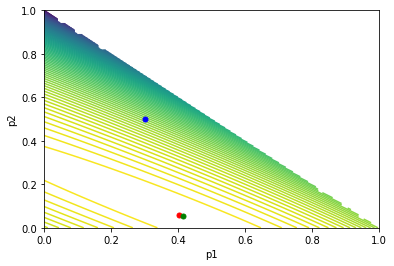

- Paramater values with best loglikelihood -
p1 = [0.4040404]
p2 = [0.06060606]
p3 = [0.53535354]
likelihood = -11526.429204929875
red = -11526.429204929875, blue = [11786.80551512], green = [11526.41869065]


In [65]:
# make contour plot
fig = plt.figure()
plt.contour(x, y, ll, 100)
plt.xlabel("p1")
plt.ylabel("p2")

## retrieve position of highest likelihood and plot point
max_ll_poss = np.where(ll==np.amax(ll))
max_x = x[max_ll_poss[1]]
max_y = y[max_ll_poss[0]]
plt.plot(max_x, max_y, color="red", marker = "o", markersize=5)

# place marker at actual input values
plt.plot(in_wp[0], in_wp[1], color="blue", marker = "o", markersize=5)

# place marker at optimized values
plt.plot(optimized_vals[1], optimized_vals[0], color="green", marker = "o", markersize=5)

# show plot
plt.show()

# show paramater values
print("- Paramater values with best loglikelihood -\n"
      "p1 = {}\n"
      "p2 = {}\n"
      "p3 = {}\n"
      "likelihood = {}".format(max_x, max_y, (1 - max_x - max_y), np.amax(ll)))

print("red = {}, blue = {}, green = {}".format(np.amax(ll), actual_ll, model.fun))

The contour plot above shows the highest likelihood (red marker) and the likelihood of the input paramaters for p1 & p2 (0.5, 0.3) (blue marker) and the likelihood of the optimizer (green marker). This shows visually the paramaters which give the best likelihood are different to those used as input. The paramaters and likelihood retreved from the grid search  are very close to those found by the optimizer (differences likely due to reduced precision in the grid search as they return similar likelihoods), suggesting the optimizer is in fact finding the highest likelihood as designed.

The question is: Why do there exist paramaters that produce a higher likelihood than those used to create the data? The answer likely is due to the model fitting to random variations in the data; over fitting. How can this be tested?

Combined this shows the minimization routine is able to return the p weighting paramaters with the highest likelihood for a sum of exponential model with known rate values.

#### Sampling with unknown rate values

To try and maximise the rate values in addition to the p weights the functions specified above need to be modified to accept more paramaters.

In [5]:
# set seed on random number generator for demonstrating
np.random.seed(7)

def render(size, params, x):
    eq, args = symbolise(*build_equation(size))
    func = sympy.lambdify(args, eq)
    # fix rates
    pnumber = size - 1
    #rates = [1.6, 1.11, 0.7]
    #params = [*rates, *params]
    f_args = [*params, x]
    return func(*f_args)

def penalty(params):
    # impose penalty if the sum of paramaters is not between 0 and 1 and if 1 - sum
    # params is greater than 1 or less than 0
    pi = int(len(params) - np.ceil((len(params) / 2)))
    if 1 - sum(params[-pi:]) > 1 or 1 - sum(params[-pi:]) < 0:
        return np.inf
    elif sum(params[-pi:]) > 1 or sum(params[-pi:]) < 0:
        return np.inf
    return False

Now we can produce the same model but ask the minimizer to produce the rates as well.

In [6]:
# set seed on random number generator for demonstrating
np.random.seed(7)

# Set the data size and dictionary or probabilities and rates for sumexp sampling
data_size = 10000
comb = {0.3:1.6,
        0.5:1.11,
        0.2:0.7}

# generate data from sum of exponentials function defined
simdata = sample_sumexp(data_size, comb)

# set size as number of rate values
size = 3

# starting estimates (rate values of 1 return worse likelihood. 0.1 does the job)
startest = [0.1, 0.1, 0.1, 0.3, 0.3]

# bounds (changed here to include rates)
bounds = (((0, None),) * size) + (((0, 1),) * (size -1))

# run the model
model = minimize_model(simdata, startest, bounds)
print(model)

pi = 2
pl = eval("1 - {}".format("-".join([str(i) for i in model.x[-pi:]])))
model_params = [i for i in model.x]
model_params.append(pl)
optimized_vals = model.x[-pi:]
print("\n- Input paramater values -")
print(list(comb.values()) + list(comb.keys()))
print("\n- Estimated paramater values -")
print(model_params)

# see how loglikelihood compares to the actual paramaters used
params = list(comb.values()) + list(comb.keys())[:2]
sim_rates = model.x[:3]
actual_ll = minimize_nll(params, simdata)
print("\nInput paramater likelihood = {}".format(actual_ll))

      fun: array([11526.65189789])
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.10040822,  0.10040822,  0.0343789 , -0.08312782, -0.08312782])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 198
      nit: 22
   status: 0
  success: True
        x: array([0.71321203, 0.71321203, 1.19671246, 0.29222464, 0.29222464])

- Input paramater values -
[1.6, 1.11, 0.7, 0.3, 0.5, 0.2]

- Estimated paramater values -
[0.7132120287346584, 0.7132120287346584, 1.1967124626338512, 0.29222464498688916, 0.29222464498688916, 0.4155507100262217]

Input paramater likelihood = [11786.80551512]


Some of the p weights here are close to the input values, but most of the paramaters otpimised are quite different to the values used in the sampling. A way to test this is to plot the likelihood curve like before, however, this is difficult to visualise with more than 3 paramaters.

It could also be that this combination of rate and p weightings is equivilent to the input values for rate and p weightings.

One way to test this is to plot the likelihood contour for p weights with the rate paramaters optimised fixed in the model to see if the p weights are the best for these rate values. Fist we need to reset the functions we previously changed.

In [7]:
# set seed on random number generator for demonstrating
np.random.seed(7)

def render(size, params, x):
    eq, args = symbolise(*build_equation(size))
    func = sympy.lambdify(args, eq)
    # fix rates
    pnumber = size - 1
    # rates changed here to what the function above returned
    rates = sim_rates
    params = [*rates, *params]
    f_args = [*params, x]
    return func(*f_args)

def penalty(params):
    # impose penalty if the sum of paramaters is not between 0 and 1 and if 1 - sum
    # params is greater than 1 or less than 0
    if 1 - sum(params) > 1 or 1 - sum(params) < 0:
        return np.inf
    elif sum(params) > 1 or sum(params) < 0:
        return np.inf
    return False

def minimize_nll(params, x):
    size = 3
    cost = penalty(params)
    if cost:
        return cost
    loglike = sum(np.log(render(size, params, x)))
    return -loglike

Now we can plot the likelihood contour just as before.

In [83]:
# set seed on random number generator for demonstrating
np.random.seed(7)

# get data for contour plot
x = y = np.linspace(0, 1, 100)
ll = np.zeros((len(x), len(y)))
for i in range(len(x)):
    for j in range(len(y)):
        ll[i][j] = -minimize_nll([x[i], y[j]], simdata)

0.29222464498688916 0.29222464498688916


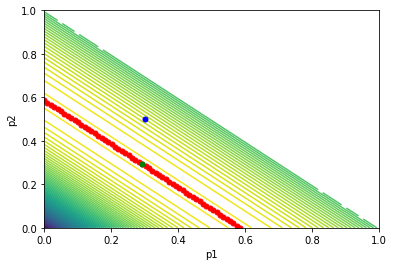

- Paramater values with best loglikelihood -
p1 = [0.58585859 0.57575758 0.56565657 0.55555556 0.54545455 0.53535354
 0.52525253 0.51515152 0.50505051 0.49494949 0.48484848 0.47474747
 0.46464646 0.45454545 0.44444444 0.43434343 0.42424242 0.41414141
 0.4040404  0.39393939 0.38383838 0.37373737 0.36363636 0.35353535
 0.34343434 0.33333333 0.32323232 0.31313131 0.3030303  0.29292929
 0.28282828 0.27272727 0.26262626 0.25252525 0.24242424 0.23232323
 0.22222222 0.21212121 0.2020202  0.19191919 0.18181818 0.17171717
 0.16161616 0.15151515 0.14141414 0.13131313 0.12121212 0.11111111
 0.1010101  0.09090909 0.08080808 0.07070707 0.06060606 0.05050505
 0.04040404 0.03030303 0.02020202 0.01010101 0.        ]
p2 = [0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.252

In [86]:
# make contour plot
fig = plt.figure()
plt.contour(x, y, ll, 100)
plt.xlabel("p1")
plt.ylabel("p2")

## retrieve position of highest likelihood and plot
max_ll_poss = np.where(ll==np.amax(ll))
max_x = x[max_ll_poss[1]]
max_y = y[max_ll_poss[0]]
plt.plot(max_x, max_y, color="red", marker = "o", markersize=5)

# place marker at actual input values
plt.plot(in_wp[0], in_wp[1], color="blue", marker = "o", markersize=5)

# place marker at optimized values
print(optimized_vals[1], optimized_vals[0])
plt.plot(optimized_vals[1], optimized_vals[0], color="green", marker = "o", markersize=5)

# show plot
plt.show()

# show paramater values
print("- Paramater values with best loglikelihood -\n"
      "p1 = {}\n"
      "p2 = {}\n"
      "p3 = {}\n"
      "likelihood = {}".format(max_x, max_y, (1 - max_x - max_y), np.amax(ll)))

print("red = {}, blue = {}, green = {}".format(np.amax(ll), actual_ll, model.fun))

The mle returned here is very close to that the optimizer has returned and appear at the same level on the plot.

When comparing the contour plots when rates are fixed vs when rates are free, the shape of the peaks are different. When fixed at the input rates, the peak forms an oval shape, whereas when free the peak is more of a diagonal band across the plot. It it also of note that the optimizer appears to set the rates in a similar manner to how it sets the p weights, keeping the first 2 as close to each other as possible and varying the 3rd.

Rather than a single red point, the grid search shows there are multiple different p weight combinations that produce the same likelihood. This is likely because the rate values have been set very close to each other by the optimizer, allowing p weights to be interchangable between rates thereby increasing possible paramater combinations. 

The mle estimate is the same between fixed and free rate models indicating the minimizer is able to optimize rates as well as p weights to return the highest likelihood. It should be noted that just as for the p weights, the starting values for the rates are imporant. When set to 1 the optimizer converges on a worse likelihood. The solution appears to be to set them as close to zero as possible to convince the optimizer to vary these values.

#### Difference between actual paramater values and optimized values

The question remains as to why the rate and p weight values are different to those used in the sampling. One explanation could be that the overall shape is the same despite individual differences in paramater values. In other words, different paramater combinations can produce the same or similar data. A way to test this is to plot the data predicted by the model against the actual data to see if it produces a good fit. The following functions provide this fitting ability by plotting the cdf of the data along with the cdf of the model.

In [8]:
def inverse_cdf(data):
    sorted_data = -np.sort(-data)
    prob = np.arange(0, len(data), 1) / len(data)
    return pd.DataFrame({"SortedData":sorted_data, "Probability":prob})

def cdf_func(params, x):
    eq, args = symbolise(*build_equation(size))
    cdf = sympy.integrate(eq, args[-1])
    func = sympy.lambdify(args, cdf)
    f_args = [*params, x]
    return 1 - (func(*f_args) + 1)


def predict(data, prest, fun):
    ivdata = inverse_cdf(data)
    lengths = np.linspace(max(data),
                          min(data),
                          num = len(data))
    params = [prest, lengths]
    prediction = np.array(fun(*params))
    df = pd.DataFrame({"SortedData"  : ivdata["SortedData"],
                       "Probability" : ivdata["Probability"],
                       "Lengths"     : lengths,
                       "Prediction"  : prediction})
    return df


def predict_fig(data, prest, fun, method, xlab, ylab):
    df = predict(data, prest, fun)
    plt.figure()
    l1 = plt.plot(df["SortedData"],
                  df["Probability"],
                  label = "data")
    l2 = plt.plot(df["Lengths"],
                  df["Prediction"],
                  label = method)
    plt.legend(handles = [l1[0], l2[0]])
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    return plt


<module 'matplotlib.pyplot' from '/home/joe/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

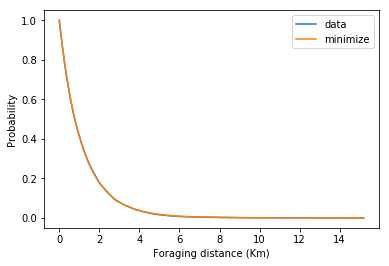

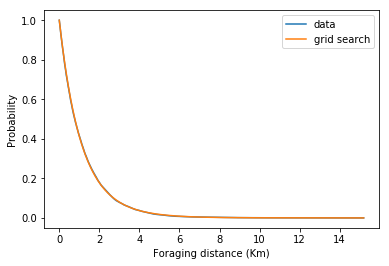

In [9]:
simdata = simdata.flatten()

# figure from minimize
predict_fig(simdata, model.x, cdf_func, "minimize",
                           "Foraging distance (Km)",
                           "Probability")

inparams = [1.2910362377100586, 0.8926545807940686, 0.6067446941362831, 0.20408163, 0.57142857]
predict_fig(simdata, inparams, cdf_func, "grid search",
                           "Foraging distance (Km)",
                           "Probability")

(__Section needs work__)

The above figures show the actual data generated from simulating using known paramaters (blue line) along with the data generated from the paramaters for highest log-likelihood (orange line) identified from minimized (top figure) and grid search routines (bottom figure).

This plot demonstrates that although the maximisation routine is returning different paramaters to those used in sampling, the model is as good. This suggests different paramater combinations can produce the same or similar data. It is notable, however, that the likelihood for the paramaters used to simulate the data is -11786, where as the optimised likelihood is -11526, a difference of 260 with a sample size of 10,000. This difference is likely down to the model fitting to the random variations in the data, suggesting the model could be over fitting.

Whilst the actual paramater values and those with the highest likelihood are not exactly the same, this is likely due to random variations in the data. When the rate values are not fixed however, these values change along with the weighting values to produce the same likelihood as to when the rates are fixed. The fact the values are different to those used in simulation could be either an effect of using weights, allowing multiple different paramater combinations that produce the same distribution shape, or evidence of the model overfitting to random variations in the data (or a combination of both, question is why is the grid search and the minimizer producing better paramater estimates than those used with such a large ammount of data? This looks to me like it is over fitting). 

#### Fitting 3 rate sum of exponentials to 2 rate sample

So far we have shown the sum of exponentials equation can accuratly model data sample from a sum of exponentials distribution. However, a key facet of the model is the ability to reduce down to the actual underlying distribution. In other words, if the data is gathered from a 2 rate sum of exponential then when fitting a 3 rate sum of exponential it should set one of the p weights to 0 to remove the extra un-nessesary rate paramater. The following code tests this ability.

In [10]:
# set seed on random number generator for demonstrating
np.random.seed(7)

def render(size, params, x):
    eq, args = symbolise(*build_equation(size))
    func = sympy.lambdify(args, eq)
    # fix rates
    pnumber = size - 1
    # rates changed
    rates = [1.6, 1.11, 0.7]
    params = [*rates, *params]
    f_args = [*params, x]
    return func(*f_args)

def penalty(params):
    # impose penalty if the sum of paramaters is not between 0 and 1 and if 1 - sum
    # params is greater than 1 or less than 0
    if 1 - sum(params) > 1 or 1 - sum(params) < 0:
        return np.inf
    elif sum(params) > 1 or sum(params) < 0:
        return np.inf
    return False

def minimize_nll(params, x):
    size = 3
    cost = penalty(params)
    if cost:
        return cost
    loglike = sum(np.log(render(size, params, x)))
    return -loglike

In [11]:
# set seed on random number generator for demonstrating
np.random.seed(7)

# Set the data size and dictionary or probabilities and rates for sumexp sampling
data_size = 10000
comb = {0.51 : 1.6,
        0.49 : 1.11,
        0    : 0.7}
in_wp = list(comb.keys())[:2]

# generate data from sum of exponentials function defined
simdata = sample_sumexp(data_size, comb)

# set size as number of rate values
size = 3

# starting estimates
startest = [0.3, 0.3]

# bounds
bounds = ((0, 1),) * (size -1)

# run the model
model = minimize_model(simdata, startest, bounds)

# show results
p3 = eval("1 - {}".format("-".join([str(i) for i in model.x])))
p1, p2 = [i for i in model.x]
optimized_vals = [p1, p2, p3]
print("-Model-\n{}\n\n"
      "- {} Simulations -\n"
      "Input p values     : {}\n"
      "Estimated p values : {}\n\n".format(model,
                                            data_size,
                                            list(comb.keys()),
                                            optimized_vals))

# see how loglikelihood compares to the actual paramaters used
actual_ll = minimize_nll(in_wp, simdata)
print("\nInput paramater likelihood = {}".format(actual_ll))

-Model-
      fun: array([12982.04107744])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.50511221, -0.00782165])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 33
      nit: 8
   status: 0
  success: True
        x: array([0.        , 0.14796349])

- 10000 Simulations -
Input p values     : [0.51, 0.49, 0]
Estimated p values : [0.0, 0.14796348529335102, 0.852036514706649]



Input paramater likelihood = [14834.29680119]


Here the optimizer has reduced the first paramater to 0 as desired, showing the optimization routine can effectivley reduce from a three paramater model to match the data distribution. The following contour plots show the sample space.

In [122]:
# get data for contour plot
x = y = np.linspace(0, 1, 100)
ll = np.zeros((len(x), len(y)))
for i in range(len(x)):
    for j in range(len(y)):
        ll[i][j] = -minimize_nll([x[i], y[j]], simdata)

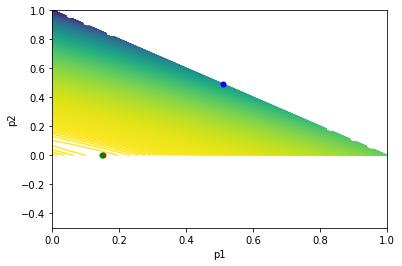

- Paramater values with best loglikelihood -
p1 = [0.15151515]
p2 = [0.]
p3 = [0.84848485]
likelihood = -12982.051335863942
red = -12982.051335863942, blue = [14834.29680119], green = [12982.04107744]


In [127]:
# make contour plot
fig = plt.figure()
plt.contour(x, y, ll, 1000)
plt.xlabel("p1")
plt.ylabel("p2")

## retrieve position of highest likelihood and plot point
max_ll_poss = np.where(ll==np.amax(ll))
max_x = x[max_ll_poss[1]]
max_y = y[max_ll_poss[0]]
plt.plot(max_x, max_y, color="red", marker = "o", markersize=5)

# place marker at actual input values
plt.plot(in_wp[0], in_wp[1], color="blue", marker = "o", markersize=5)

# place marker at optimized values
plt.plot(optimized_vals[1], optimized_vals[0], color="green", marker = "o", markersize=5)

plt.ylim((-0.5,1))

# show plot
plt.show()

# show paramater values
print("- Paramater values with best loglikelihood -\n"
      "p1 = {}\n"
      "p2 = {}\n"
      "p3 = {}\n"
      "likelihood = {}".format(max_x, max_y, (1 - max_x - max_y), np.amax(ll)))

print("red = {}, blue = {}, green = {}".format(np.amax(ll), actual_ll, model.fun))

As shown in the plot, the red and green markers (grid search mle and optimized mle) are very close to the edge of the function domain. The number of levels used has been increased to show the peak around the markers. As in the other examples, the likelihood of the input paramaters is not the highest for the data. Nevertheless, the fact that the optmizer and grid search is setting a p weight to 0 suggests the optimisation is effectivley fitting the data.

Next we need to see if the optimization can acheive the same results with free rate paramaters.

In [12]:
# set seed on random number generator for demonstrating
np.random.seed(7)

def render(size, params, x):
    eq, args = symbolise(*build_equation(size))
    func = sympy.lambdify(args, eq)
    # fix rates
    pnumber = size - 1
    #rates = [1.6, 1.11, 0.7]
    #params = [*rates, *params]
    f_args = [*params, x]
    return func(*f_args)

def penalty(params):
    # impose penalty if the sum of paramaters is not between 0 and 1 and if 1 - sum
    # params is greater than 1 or less than 0
    pi = int(len(params) - np.ceil((len(params) / 2)))
    if 1 - sum(params[-pi:]) > 1 or 1 - sum(params[-pi:]) < 0:
        return np.inf
    elif sum(params[-pi:]) > 1 or sum(params[-pi:]) < 0:
        return np.inf
    return False

In [21]:
# set seed on random number generator for demonstrating
np.random.seed(7)

# Set the data size and dictionary or probabilities and rates for sumexp sampling
data_size = 10000
comb = {0.51 : 1.6,
        0.49 : 1.11,
        0    : 0.7}
in_wp = list(comb.values()) + list(comb.keys())[:2]

# generate data from sum of exponentials function defined
simdata = sample_sumexp(data_size, comb)

# set size as number of rate values
size = 3

# starting estimates (rate values of 1 return worse likelihood. 0.1 does the job)
startest = [0.1, 0.1, 0.1, 0.3, 0.3]

# bounds (changed here to include rates)
bounds = (((0, None),) * size) + (((0, 1),) * (size -1))

# run the model
model = minimize_model(simdata, startest, bounds)

# show results
pi = 2
p3 = eval("1 - {}".format("-".join([str(i) for i in model.x[-pi:]])))
p1, p2 = [i for i in model.x[-pi:]]
optimized_vals = [p1, p2, p3]
print("-Model-\n{}\n\n"
      "- {} Simulations -\n"
      "Input p values     : {}\n"
      "Estimated p values : {}\n\n".format(model,
                                            data_size,
                                            list(comb.keys()),
                                            optimized_vals))

# see how loglikelihood compares to the actual paramaters used
actual_ll = minimize_nll(in_wp, simdata)
print("\nInput paramater likelihood = {}".format(actual_ll))

[0.6707782063771918, 0.6707782063771918, 0.8484419492780346, 0.27052800316261105, 0.27052800316261105]
-Model-
      fun: array([12981.84415587])
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.04129106, -0.04129106,  0.03674359,  0.09440555,  0.09440555])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 66
      nit: 9
   status: 0
  success: True
        x: array([0.67077821, 0.67077821, 0.84844195, 0.270528  , 0.270528  ])

- 10000 Simulations -
Input p values     : [0.51, 0.49, 0]
Estimated p values : [0.27052800316261105, 0.27052800316261105, 0.4589439936747779]



Input paramater likelihood = [14834.29680119]


With free paramater rates the optimizer does not redude a p weight to 0. However, the likelihood returned is higher than when rates are fixed. This suggests the optimizer is overfitting to random variations in the data and, being only 1 integer higher than when a rate is set to 0, would be negativley penalised with AIC. This poses a problem as the optimizer will just overfit by always going for the highest likelihood. A method around this would be to convert the likelihood to an AIC score within the optimization routine. This would also require a step to recognise 0 values and reduce the number of paramaters in the AIC accordingly, as a paramater of 0 removes that paramater from the model. The starting values also need to be considered. Setting all p weights to 0 means the optimizer starts from a single exponential.

The following code provides this functionality and retests.

In [46]:
def aic_eq(ll, params):
    #print(params)
    k = len(params)
    for i in params:
        if i == 0:
            k = k -1
    return -2 * ll + 2 * k

def minimize_nll(params, x):
    size = 3
    cost = penalty(params)
    if cost:
        return cost
    loglike = sum(np.log(render(size, params, x)))
    return aic_eq(loglike, params)

-Model-
      fun: array([25971.48762504])
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00,  0.00000000e+00, -3.05590220e-02,  1.99998958e+08,
        1.99998958e+08])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 54
      nit: 7
   status: 0
  success: True
        x: array([0.1       , 0.1       , 0.74209713, 0.        , 0.        ])

- 10000 Simulations -
Input p values     : [0.51, 0.49, 0]
Estimated p values : [0.0, 0.0, 1.0]


[1.6, 1.11, 0.7, 0.51, 0.49]

Input paramater likelihood = [29678.59360238]
[0.1        0.1        0.74209713 0.         0.        ]


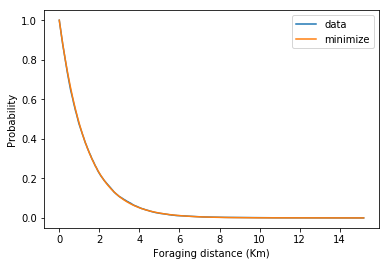

In [56]:
# set seed on random number generator for demonstrating
np.random.seed(7)

# Set the data size and dictionary or probabilities and rates for sumexp sampling
data_size = 10000
comb = {0.51 : 1.6,
        0.49 : 1.11,
        0    : 0.7}
in_wp = list(comb.values()) + list(comb.keys())[:2]

# generate data from sum of exponentials function defined
simdata = sample_sumexp(data_size, comb)

# set size as number of rate values
size = 3

# starting estimates (rate values of 1 return worse likelihood. 0.1 does the job)
startest = [0.1, 0.1, 0.1, 0, 0]

# bounds (changed here to include rates)
bounds = (((0, None),) * size) + (((0, 1),) * (size -1))

# run the model
model = minimize_model(simdata, startest, bounds)

# show results
pi = 2
p3 = eval("1 - {}".format("-".join([str(i) for i in model.x[-pi:]])))
p1, p2 = [i for i in model.x[-pi:]]
optimized_vals = [p1, p2, p3]
print("-Model-\n{}\n\n"
      "- {} Simulations -\n"
      "Input p values     : {}\n"
      "Estimated p values : {}\n\n".format(model,
                                            data_size,
                                            list(comb.keys()),
                                            optimized_vals))

# see how loglikelihood compares to the actual paramaters used
print(in_wp)
actual_ll = minimize_nll(in_wp, simdata)
print("\nInput paramater likelihood = {}".format(actual_ll))

# figure from minimize
simdata = simdata.flatten()
predict_fig(simdata, model.x, cdf_func, "minimize",
                           "Foraging distance (Km)",
                           "Probability")
print(model.x)

This is interesting. By using the AIC with a method of reducing k when paramater values are 0 we have directly minimized the AIC score. The optimizer has managed to find a good fit with just a single exponential.

__Concerns:__ The test above showed that a single exponential can fit a sum of exponential distribution with 3 rates. Our previous routine used only loglikelihood and so would always return the highest value. However, the number of paramaters increases loglikelihood, so the routine would benefit from choosing more paramaters. By using the AIC mechanism which takes into account paramater number the optimizer will benefit from trying to reduce the number of paramaters in the model. However, in our test above it reduced a 3 paramater sumexp to a single exponential. To make sure it works as it should we need to know it can vary multiple rates when required and not just only work with a single exponential. More testing follows.

-Model-
      fun: array([24325.24256171])
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.06621121, -0.06621121, -0.01928129,  0.06184564,  0.06184564])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 300
      nit: 37
   status: 0
  success: True
        x: array([0.3914819 , 0.3914819 , 3.36930459, 0.25879561, 0.25879561])

- 10000 Simulations -
Input p values     : [0.51, 0.49, 0]
Estimated p values : [0.25879560712871075, 0.25879560712871075, 0.4824087857425785]


[2.6, 0.3, 1, 0.51, 0.49]

Input paramater likelihood = [24604.58986245]
[0.3914819  0.3914819  3.36930459 0.25879561 0.25879561]


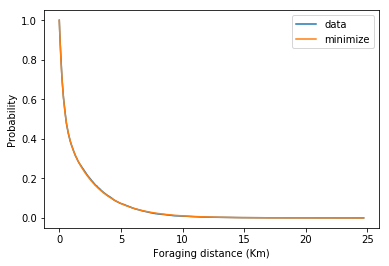

In [63]:
# set seed on random number generator for demonstrating
np.random.seed(7)

# Set the data size and dictionary or probabilities and rates for sumexp sampling
data_size = 10000
comb = {0.51 : 2.6,
        0.49 : 0.3,
        0    : 1}
in_wp = list(comb.values()) + list(comb.keys())[:2]

# generate data from sum of exponentials function defined
simdata = sample_sumexp(data_size, comb)

# set size as number of rate values
size = 3

# starting estimates (rate values of 1 return worse likelihood. 0.1 does the job)
startest = [0.1, 0.1, 0.1, 0, 0]

# bounds (changed here to include rates)
bounds = (((0, None),) * size) + (((0, 1),) * (size -1))

# run the model
model = minimize_model(simdata, startest, bounds)

# show results
pi = 2
p3 = eval("1 - {}".format("-".join([str(i) for i in model.x[-pi:]])))
p1, p2 = [i for i in model.x[-pi:]]
optimized_vals = [p1, p2, p3]
print("-Model-\n{}\n\n"
      "- {} Simulations -\n"
      "Input p values     : {}\n"
      "Estimated p values : {}\n\n".format(model,
                                            data_size,
                                            list(comb.keys()),
                                            optimized_vals))

# see how loglikelihood compares to the actual paramaters used
print(in_wp)
actual_ll = minimize_nll(in_wp, simdata)
print("\nInput paramater likelihood = {}".format(actual_ll))

# figure from minimize
simdata = simdata.flatten()
predict_fig(simdata, model.x, cdf_func, "minimize",
                           "Foraging distance (Km)",
                           "Probability")
print(model.x)

Using different rates the optimizer has been able to identify the best fit and grow from a single explonential as the start of trials to a sum of exponentials. The method of minimizing the AIC score rather than the likelihood appears to be the correct approach, but I need to speak with Vincent about it. The following tests use this AIC method.

#### Expansion to $n$ paramaters 

So far we have showed the optimization routine is accuratly modeling the data with both rates fixed and free up to 3 rate paramaters. However, the main strength of the function is the ability to fit to data over $n$ parameters. To ensure this is occuring, we need to test the optimiser is effective for $n$ rate paramaters, including when multipe rates are 0 to test model reducability. 

Before jumping to $n$ paramaters the following section repeats the testing done above on a 5 rate parameter sum of exponentials (4 p weight parameters). The major problem at this stage is the selection of starting paramaters for the p weights. The difficulty in varying p weights by the optimiser is inversley proportional to the number of p weights. In other words, as the number of p weights increases the space for the optmizer to vary them narrows. The result is the optimizer qucikly assumes any changes return a lower likelihood and it can't properly explore the paramater space.

__? Solutions ?__   

1) [Lagrange Multipliers](http://people.duke.edu/~hpgavin/cee201/LagrangeMultipliers.pdf) To remove the need for an inbuilt penalty function and instead follow the minimisation of the Lagrange function. [Another link to info](https://www.khanacademy.org/math/multivariable-calculus/applications-of-multivariable-derivatives/constrained-optimization/a/lagrange-multipliers-examples). __Not sure if applicable to this type of constraint problem! (ask Vincent)__

2) Randomly sample different p weight starting values and try the minimization untill it is successfull. __Time consuming and will increase with number of paramaters!__

3) Decrease step size in optimizer to allow it to explore more. __Not sure if this is possible in the optimiser.__

4) Divide p weight starting paramaters by the number of rates to lower them so increases are small. __Best option to try first.__


First up, fixed rates.

In [148]:
# rest functions
# set seed on random number generator for demonstrating
np.random.seed(7)

def render(size, params, x):
    eq, args = symbolise(*build_equation(size))
    func = sympy.lambdify(args, eq)
    # fix rates
    pnumber = size - 1
    # rates increased to five
    rates = [1.6, 1.11, 0.7, 2.1, 0.8]
    params = [*rates, *params]
    f_args = [*params, x]
    return func(*f_args)

def penalty(params):
    # impose penalty if the sum of paramaters is not between 0 and 1 and if 1 - sum
    # params is greater than 1 or less than 0
    if 1 - sum(params) > 1 or 1 - sum(params) < 0:
        return np.inf
    elif sum(params) > 1 or sum(params) < 0:
        return np.inf
    return False

def minimize_nll(params, x):
    size = 5
    cost = penalty(params)
    if cost:
        print(params, cost)
        return cost
    loglike = sum(np.log(render(size, params, x)))
    print(params, -loglike)
    return -loglike

In [151]:
# set seed on random number generator for demonstrating
np.random.seed(7)

# Set the data size and dictionary or probabilities and rates for sumexp sampling
data_size = 10000
comb = {0.2  : 1.6,
        0.3  : 1.11,
        0.1  : 0.7,
        0.25 : 2.1,
        0.15 : 0.8}
in_wp = list(comb.keys())[:4]

# generate data from sum of exponentials function defined
simdata = sample_sumexp(data_size, comb)

# set size as number of rate values
size = 5

# starting estimates
startest = [0.3, 0.2, 0.1, 0.01]

# bounds
bounds = ((0, 1),) * (size -1)

# run the model
model = minimize_model(simdata, startest, bounds)

# show results
p5 = eval("1 - {}".format("-".join([str(i) for i in model.x])))
p1, p2, p3, p4 = [i for i in model.x]
optimized_vals = [p1, p2, p3, p4, p5]
print("-Model-\n{}\n\n"
      "- {} Simulations -\n"
      "Input p values     : {}\n"
      "Estimated p values : {}\n\n".format(model,
                                            data_size,
                                            list(comb.keys()),
                                            optimized_vals))

# see how loglikelihood compares to the actual paramaters used
actual_ll = -minimize_nll(in_wp, simdata)
print("\nInput paramater likelihood = {}".format(actual_ll))

[0.3  0.2  0.1  0.01] [13354.57254518]
[0.30000001 0.2        0.1        0.01      ] [13354.57256146]
[0.3        0.20000001 0.1        0.01      ] [13354.57255488]
[0.3        0.2        0.10000001 0.01      ] [13354.57253939]
[0.3        0.2        0.1        0.01000001] [13354.57256471]
[0. 0. 1. 0.] [13026.9103046]
[1.e-08 0.e+00 1.e+00 0.e+00] inf
[0.e+00 1.e-08 1.e+00 0.e+00] inf
[0.         0.         1.00000001 0.        ] inf
[0.e+00 0.e+00 1.e+00 1.e-08] inf
[0. 0. 1. 0.] [13026.9103046]
[1.e-08 0.e+00 1.e+00 0.e+00] inf
[0.e+00 1.e-08 1.e+00 0.e+00] inf
[0.         0.         1.00000001 0.        ] inf
[0.e+00 0.e+00 1.e+00 1.e-08] inf
[0. 0. 1. 0.] [13026.9103046]
[1.e-08 0.e+00 1.e+00 0.e+00] inf
[0.e+00 1.e-08 1.e+00 0.e+00] inf
[0.         0.         1.00000001 0.        ] inf
[0.e+00 0.e+00 1.e+00 1.e-08] inf
[0. 0. 1. 0.] [13026.9103046]
[1.e-08 0.e+00 1.e+00 0.e+00] inf
[0.e+00 1.e-08 1.e+00 0.e+00] inf
[0.         0.         1.00000001 0.        ] inf
[0.e+00 0.e+00 

In [145]:
# set seed on random number generator for demonstrating
np.random.seed(7)

# Set the data size and dictionary or probabilities and rates for sumexp sampling
data_size = 10000
comb = {0.2  : 1.6,
        0.4  : 1.11,
        0    : 0.7,
        0.25 : 2.1,
        0.15 : 0.8}
in_wp = list(comb.keys())[:4]

# generate data from sum of exponentials function defined
simdata = sample_sumexp(data_size, comb)

# set size as number of rate values
size = 5

# starting estimates
startest = [0.2, 0.2, 0.1, 0.1]

# bounds
bounds = ((0, 1),) * (size -1)

# run the model
model = minimize_model(simdata, startest, bounds)

# show results
p5 = eval("1 - {}".format("-".join([str(i) for i in model.x])))
p1, p2, p3, p4 = [i for i in model.x]
optimized_vals = [p1, p2, p3, p4, p5]
print("-Model-\n{}\n\n"
      "- {} Simulations -\n"
      "Input p values     : {}\n"
      "Estimated p values : {}\n\n".format(model,
                                            data_size,
                                            list(comb.keys()),
                                            optimized_vals))

# see how loglikelihood compares to the actual paramaters used
actual_ll = -minimize_nll(in_wp, simdata)
print("\nInput paramater likelihood = {}".format(actual_ll))

-Model-
      fun: array([13784.8950429])
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([1926.32051039, 1108.98781713, -628.35697463, 2358.25591517])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 105
      nit: 0
   status: 2
  success: False
        x: array([0.2, 0.2, 0.1, 0.1])

- 10000 Simulations -
Input p values     : [0.2, 0.4, 0, 0.25, 0.15]
Estimated p values : [0.2, 0.2, 0.1, 0.1, 0.40000000000000013]



Input paramater likelihood = [-14816.87052866]
